## Learning from Isochrones: A machine learning approach to estimating stellar properties

### Part 0 - Creating the testing data with regression

##### Luco Buise (s1055446)

---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip
import random as ran

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
# defining some functions for creation of training data

# load open cluster data into BV and V data
def load_oc_data(name):
    V, BV = np.loadtxt(name, usecols=(2, 3), unpack=True)

    return BV, V

# load globular cluster data into BV and V data, but only for measurements with specific error margins
def load_gc_data(name):
    B, B_err, V, V_err = np.loadtxt(name, usecols=(6,7,9,10), unpack=True)
    w = np.where(B_err + V_err < 0.005)

    return B[w] - V[w], V[w]

# get the regressed and sampled form of star cluster data
def get_regressed_data(BV, V, sample_size = 100):
    y = np.array([y for _, y in sorted(zip(BV, V))])
    x = np.array(sorted(BV))
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    x = torch.unsqueeze(x, dim=1)
    y = torch.unsqueeze(y, dim=1)
    
    model = define_train_model(x,y)

    BV_new = np.array([])
    V_new = np.array([])
    
    x_predict = x
    y_predict = np.array([model(x_predict).data.numpy() for k in range(10000)])
    y_predict = y_predict[:,:,0]    
    y_predict = y_predict.T    
    y_predict = np.array([y_predict[i].mean() for i in range(len(y_predict))])
    
    for i in sorted(ran.sample(range(len(x_predict)), sample_size)):
        BV_new = np.append(BV_new, x_predict[i])
        V_new = np.append(V_new, y_predict[i])
    
    return BV_new, V_new

# define and train the model used for the cluster regression
def define_train_model(x,y):
    
    reg_model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
    )

    L1_loss = nn.L1Loss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.1

    optimizer = optim.Adam(reg_model.parameters(), lr=0.01)
    
    # start training
    for step in range(3000):
        pre = reg_model(x)
        L1 = L1_loss(pre, y)
        kl = kl_loss(reg_model)
        cost = L1 + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    return reg_model

In [3]:
# open clusters

#read in cluster names
with open('openClusters/file_names_oc.txt') as f:
    file_names_oc = [line.strip() for line in f.readlines()]

oc_ages, oc_mtl = np.loadtxt('openClusters/Ages_and_properties.txt', usecols=(1, 2), unpack=True)

X_OC = np.array([])
Y_OC = np.array([(a,z) for a,z in zip(oc_ages, oc_mtl)])

# read in the files append their regressed forms to array
for i, oc in enumerate(file_names_oc):
    BV, V = load_oc_data(oc)
    BV_reg, V_reg = get_regressed_data(BV, V)
    
    x = np.array([np.append(BV_reg, V_reg)])
    
    if len(X_OC) == 0:
        X_OC = x
    else:
        X_OC = np.append(X_OC, x, axis = 0)
        
    print("Cluster {} done!".format(i + 1))

print(X_OC.shape, Y_OC.shape)

Cluster 1 done!
Cluster 2 done!
Cluster 3 done!
Cluster 4 done!
Cluster 5 done!
Cluster 6 done!
Cluster 7 done!
Cluster 8 done!
Cluster 9 done!
Cluster 10 done!
Cluster 11 done!
Cluster 12 done!
Cluster 13 done!
Cluster 14 done!
Cluster 15 done!
Cluster 16 done!
Cluster 17 done!
Cluster 18 done!
Cluster 19 done!
Cluster 20 done!
(20, 200) (20, 2)


In [4]:
# globular clusters

#read in cluster names
with open('globClusters/file_names_gc.txt') as f:
    file_names_gc = [line.strip() for line in f.readlines()]
    
gc_mtl, gc_ages, gc_ages_err = np.loadtxt('globClusters/Ages_and_properties.txt', usecols=(2, 3, 5), unpack=True)

X_GC = np.array([])
Y_GC = np.array([(a,z) for a,z in zip(gc_ages, gc_mtl)])

# read in the files append their regressed forms to array
for i, gc in enumerate(file_names_gc):
    BV, V = load_gc_data(gc)
    BV_reg, V_reg = get_regressed_data(BV, V)
    
    x = np.array([np.append(BV_reg, V_reg)])
    
    if len(X_GC) == 0:
        X_GC = x
    else:
        X_GC = np.append(X_GC, x, axis = 0)
        
    print("Cluster {} done!".format(i + 1))

print(X_GC.shape, Y_GC.shape)

Cluster 1 done!
Cluster 2 done!
Cluster 3 done!
Cluster 4 done!
Cluster 5 done!
Cluster 6 done!
Cluster 7 done!
Cluster 8 done!
Cluster 9 done!
Cluster 10 done!
Cluster 11 done!
Cluster 12 done!
Cluster 13 done!
Cluster 14 done!
Cluster 15 done!
Cluster 16 done!
Cluster 17 done!
Cluster 18 done!
Cluster 19 done!
Cluster 20 done!
Cluster 21 done!
Cluster 22 done!
Cluster 23 done!
Cluster 24 done!
Cluster 25 done!
Cluster 26 done!
Cluster 27 done!
Cluster 28 done!
Cluster 29 done!
Cluster 30 done!
Cluster 31 done!
Cluster 32 done!
Cluster 33 done!
(33, 200) (33, 2)


In [5]:
# save the regressed data for testing purposes in other notebooks

np.save('openClusters/oc_xdata.npy', X_OC)
np.save('openClusters/oc_ydata.npy', Y_OC)

np.save('globClusters/gc_xdata.npy', X_GC)
np.save('globClusters/gc_ydata.npy', Y_GC)

In [3]:
# load again for changes in plots without having to rerun notebook
X_OC = np.load('openClusters/oc_xdata.npy')
Y_OC = np.load('openClusters/oc_ydata.npy')

X_GC = np.load('globClusters/gc_xdata.npy')
Y_GC = np.load('globClusters/gc_ydata.npy')

In [4]:
with open('openClusters/file_names_oc.txt') as f:
    file_names_oc = [line.strip() for line in f.readlines()]
    
with open('globClusters/file_names_gc.txt') as f:
    file_names_gc = [line.strip() for line in f.readlines()]

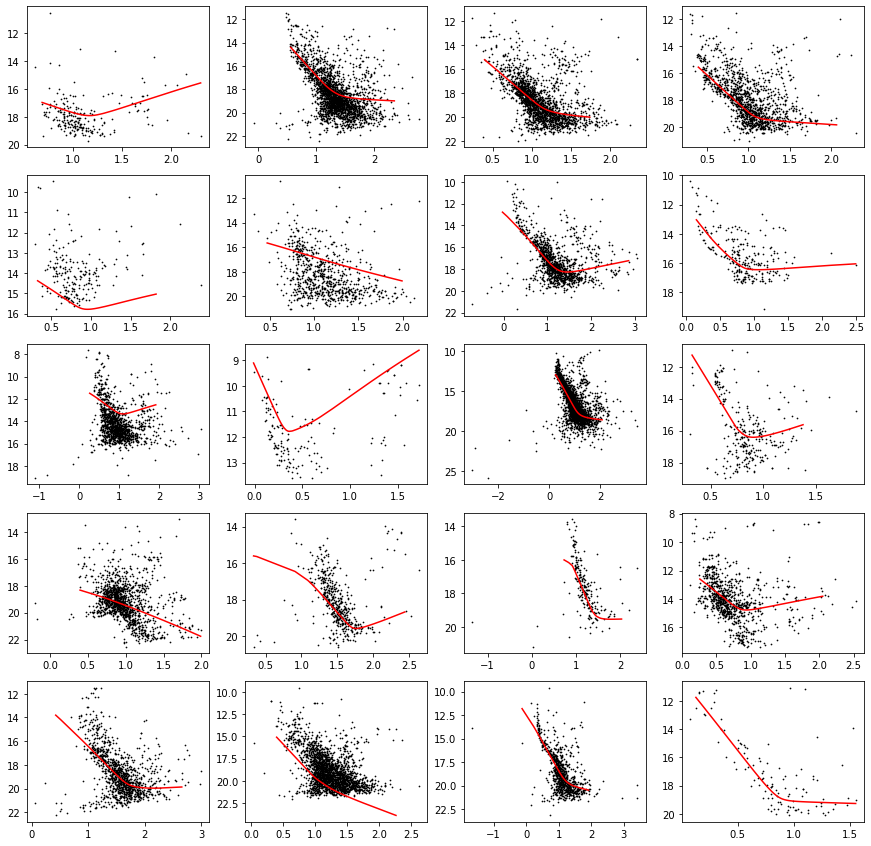

In [8]:
# plot the regressed forms
fig, axs = plt.subplots(5, 4, figsize = (15, 15))

t = 0

for i in range(5):
    for j in range(4):
        BV, V = load_oc_data(file_names_oc[t])
        axs[i,j].scatter(BV, V, s = 0.5, color = "black")
        axs[i,j].plot(X_OC[t][0:100], X_OC[t][100:], color = "red")
        axs[i,j].invert_yaxis()
        t += 1

plt.savefig('Regression_OC.png')   
plt.show()

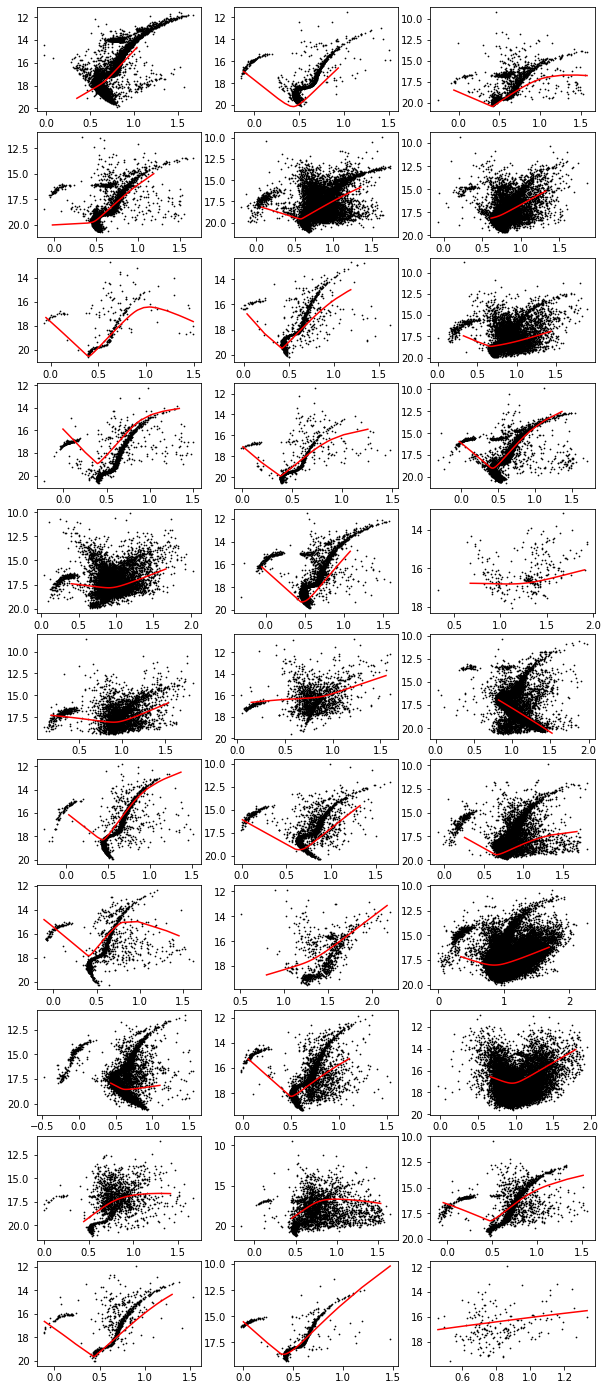

In [9]:
# plot the regressed forms
fig, axs = plt.subplots(11, 3, figsize = (10, 25))

t = 0

for i in range(11):
    for j in range(3):
        BV, V = load_gc_data(file_names_gc[t])
        axs[i,j].scatter(BV, V, s = 0.5, color = "black")
        axs[i,j].plot(X_GC[t][0:100], X_GC[t][100:], color = "red")
        axs[i,j].invert_yaxis()
        t += 1

plt.savefig('Regression_GC.png')   
plt.show()

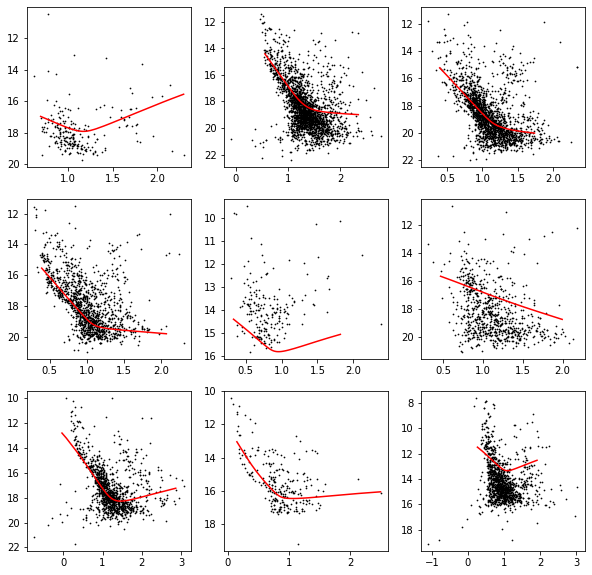

In [5]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))

t = 0

for i in range(3):
    for j in range(3):
        BV, V = load_oc_data(file_names_oc[t])
        axs[i,j].scatter(BV, V, s = 0.5, color = "black")
        axs[i,j].plot(X_OC[t][0:100], X_OC[t][100:], color = "red")
        axs[i,j].invert_yaxis()
        t += 1

plt.savefig('Small_Regression_OC.png')   
plt.show()

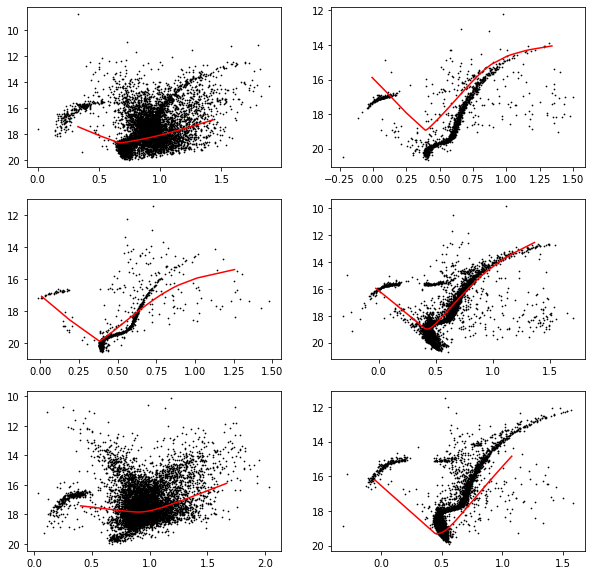

In [15]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))

t = 8

for i in range(3):
    for j in range(2):
        BV, V = load_gc_data(file_names_gc[t])
        axs[i,j].scatter(BV, V, s = 0.5, color = "black")
        axs[i,j].plot(X_GC[t][0:100], X_GC[t][100:], color = "red")
        axs[i,j].invert_yaxis()
        t += 1

plt.savefig('Small_Regression_GC.png')   
plt.show()